In [ ]:
# -*- coding: utf-8 -*-
#
#  Copyright 2024 Technical University of Denmark
#  Authored by: Piotr Budzisz (DTU)
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#  The dataset and files mentioned in the notebook belong to the CFU (Center for Fast Ultrasound Imaging) at DTU (Technical University of Denmark).
#
#  Note: The following code has been created for the purpose of a master's thesis by Piotr Budzisz titled
#  "Computational reduction of reconstruction artifacts in stitching-based biomedical computed tomography,"
#  written at the Technical University of Denmark. The file is based on and reuses parts and descriptions
#  from the Core Imaging Library notebooks created by :
#
#                   Jakob S. Jørgensen (DTU)
#                   Gemma Fardell (UKRI-STFC)
#                   Laura Murgatroyd (UKRI-STFC)
#
#  which can be found in the GitHub repository (https://github.com/TomographicImaging/CIL-Demos).
#  Copyright 2021 - 2022 United Kingdom Research and Innovation
#  Copyright 2021 - 2022 The University of Manchester
#  Copyright 2021 - 2022 Technical University of Denmark
#

# FISTA TV with 1024 padding, run for two slices

In [1]:
# CIL core components needed
from cil.framework import ImageGeometry, AcquisitionGeometry, BlockDataContainer

# CIL optimisation algorithms and linear operators
from cil.optimisation.algorithms import CGLS
from cil.optimisation.operators import BlockOperator, GradientOperator, IdentityOperator, FiniteDifferenceOperator

# CIL example synthetic test image
from cil.utilities.dataexample import SHAPES

# CIL display tools
from cil.utilities.display import show2D, show1D, show_geometry

# Forward/backprojector from CIL ASTRA plugin
from cil.plugins.astra import ProjectionOperator

# For shepp-logan test image in CIL tomophantom plugin
from cil.plugins import TomoPhantom as cilTomoPhantom

# Third-party imports
import numpy as np    
import matplotlib.pyplot as plt


from cil.framework import ImageData, ImageGeometry
from cil.framework import AcquisitionGeometry, AcquisitionData
from cil.plugins.astra.processors import FBP
from cil.processors import CentreOfRotationCorrector, Slicer, TransmissionAbsorptionConverter, Normaliser, Padder
import numpy as np
import scipy.io
import os


# apply circle mask 
from numpy import arange, meshgrid, isscalar, ndarray, pi, roll

import os
from cil.io import TIFFWriter

In [2]:
#Import Total Variation from the regularisation toolkit plugin
from cil.plugins.ccpi_regularisation.functions import FGP_TV
from cil.optimisation.algorithms import GD, FISTA, PDHG
from cil.optimisation.functions import IndicatorBox, MixedL21Norm, L2NormSquared, \
                                       BlockFunction, L1Norm, LeastSquares, \
                                       OperatorCompositionFunction, TotalVariation, \
                                       ZeroFunction

In [3]:
# circle mask
offset = 0

siz = 2048
if siz % 2:
    rang = arange(-siz / 2 + 1, siz / 2 + 1)
else:
    rang = arange(-siz / 2,siz / 2)
x,y = meshgrid(rang,rang)
z = x ** 2 + y ** 2
a = (z < (siz / 2 - abs(offset)) ** 2)

In [4]:
# constants
# set the backend for FBP and the ProjectionOperator
device = 'gpu'
# set up default colour map for visualisation
cmap = "gray"
ca1 = -0.001
ca2 = 0.002

# Slice 1: 1024 padding, 200 iterations FISTA TV with 0.5 alpha

In [5]:
# load slice
datapath = "/dtu/cfu/data/userdata18/s220464/storage/KIDNEY_DATA/"
filename = "slice1_1023_data.mat"  
all_data = scipy.io.loadmat(os.path.join(datapath,filename))
projs = all_data['X_proj'].astype(np.float32)

ag = AcquisitionGeometry.create_Parallel2D()  \
         .set_panel(num_pixels=(2048))        \
         .set_angles(angles=np.linspace(0,180,1800,endpoint=False))

ag.set_labels(['horizontal','angle'])
print(ag.dimension_labels)
data = AcquisitionData(projs, geometry=ag, deep_copy=False)

data.reorder('astra')
ig = ag.get_ImageGeometry()

A = ProjectionOperator(ig, ag, device)
padsize = 1024
data_pad_1024 = Padder.edge(pad_width={'horizontal': padsize})(data)

ag_1024 = data_pad_1024.geometry
ig_1024 = ag_1024.get_ImageGeometry()
A_1024 = ProjectionOperator(ig_1024, ag_1024, device)

('horizontal', 'angle')


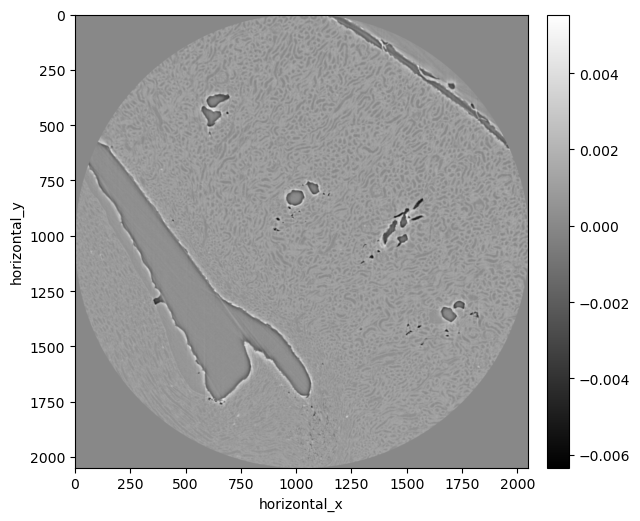

In [6]:
fbp = FBP(ig, ag_1024, device)
# run on the AcquisitionData
recon_fbp_1024 = fbp(data_pad_1024) * a
show2D(recon_fbp_1024, cmap=cmap, num_cols=1, size=(10,10), origin='upper-left')


# FISTA TV 200 iterations varying alpha

In [7]:
b = data_pad_1024
F = LeastSquares(A_1024, b)
x0 = ig_1024.allocate(0.0)

In [8]:

alpha=0

GTV = alpha*FGP_TV(nonnegativity=False, device='gpu') 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  max_iteration=1000, 
                  update_objective_interval = 10)

In [9]:
myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.31715e+08
       10       1000         2.333                     
       20       1000         2.290                     
       30       1000         2.287                     
       40       1000         2.296                     
       50       1000         2.297                     
       60       1000         2.297                     
       70       1000         2.302                     
       80       1000         2.299                     
       90       1000         2.292                     
      100       1000         2.291                     
      110       1000         2.289                     
      120       1000         2.288                     
      130       1000         2.287                     
      140       1000         2.286                     
      150       1000         2.288              

In [10]:
im_crop = Slicer(roi={'horizontal_y': (1024, 3072, 1),
                      'horizontal_x': (1024, 3072, 1)})(myFISTATV.solution)

recon_fista_tv_0 = im_crop * a

In [11]:
alpha=0.001

GTV = alpha*FGP_TV(nonnegativity=False, device='gpu') 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  max_iteration=1000, 
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.31715e+08
       10       1000         2.354          1.12024e+06
       20       1000         2.376          6.97533e+05
       30       1000         2.376          6.07058e+05
       40       1000         2.355          5.69794e+05
       50       1000         2.362          5.50817e+05
       60       1000         2.364          5.40014e+05
       70       1000         2.352          5.33264e+05
       80       1000         2.353          5.28699e+05
       90       1000         2.351          5.25415e+05
      100       1000         2.352          5.22929e+05
      110       1000         2.353          5.20965e+05
      120       1000         2.350          5.19355e+05
      130       1000         2.351          5.18000e+05
      140       1000         2.352          5.16833e+05
      150       1000         2.350          5.15

In [12]:
im_crop = Slicer(roi={'horizontal_y': (1024, 3072, 1),
                      'horizontal_x': (1024, 3072, 1)})(myFISTATV.solution)

recon_fista_tv_0001 = im_crop * a

In [13]:
alpha=0.002

GTV = alpha*FGP_TV(nonnegativity=False, device='gpu') 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  max_iteration=1000, 
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.31715e+08
       10       1000         2.390          1.12024e+06
       20       1000         2.322          6.97534e+05
       30       1000         2.326          6.07058e+05
       40       1000         2.334          5.69795e+05
       50       1000         2.340          5.50818e+05
       60       1000         2.346          5.40015e+05
       70       1000         2.343          5.33266e+05
       80       1000         2.346          5.28701e+05
       90       1000         2.348          5.25416e+05
      100       1000         2.346          5.22931e+05
      110       1000         2.349          5.20967e+05
      120       1000         2.350          5.19356e+05
      130       1000         2.348          5.18002e+05
      140       1000         2.350          5.16835e+05
      150       1000         2.351          5.15

In [14]:
im_crop = Slicer(roi={'horizontal_y': (1024, 3072, 1),
                      'horizontal_x': (1024, 3072, 1)})(myFISTATV.solution)

recon_fista_tv_0002 = im_crop * a

In [15]:
alpha=0.005

GTV = alpha*FGP_TV(nonnegativity=False, device='gpu') 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  max_iteration=1000, 
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.31715e+08
       10       1000         2.371          1.12024e+06
       20       1000         2.371          6.97535e+05
       30       1000         2.341          6.07060e+05
       40       1000         2.328          5.69797e+05
       50       1000         2.337          5.50821e+05
       60       1000         2.329          5.40018e+05
       70       1000         2.339          5.33269e+05
       80       1000         2.343          5.28704e+05
       90       1000         2.338          5.25420e+05
      100       1000         2.343          5.22935e+05
      110       1000         2.346          5.20972e+05
      120       1000         2.342          5.19362e+05
      130       1000         2.346          5.18007e+05
      140       1000         2.348          5.16841e+05
      150       1000         2.344          5.15

In [16]:
im_crop = Slicer(roi={'horizontal_y': (1024, 3072, 1),
                      'horizontal_x': (1024, 3072, 1)})(myFISTATV.solution)

recon_fista_tv_0005 = im_crop * a

In [17]:
alpha=0.01

GTV = alpha*FGP_TV(nonnegativity=False, device='gpu') 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  max_iteration=1000, 
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.31715e+08
       10       1000         2.349          1.12024e+06
       20       1000         2.360          6.97536e+05
       30       1000         2.349          6.07062e+05
       40       1000         2.353          5.69800e+05
       50       1000         2.356          5.50825e+05
       60       1000         2.351          5.40023e+05
       70       1000         2.340          5.33275e+05
       80       1000         2.349          5.28711e+05
       90       1000         2.351          5.25428e+05
      100       1000         2.345          5.22943e+05
      110       1000         2.351          5.20980e+05
      120       1000         2.353          5.19370e+05
      130       1000         2.349          5.18016e+05
      140       1000         2.353          5.16850e+05
      150       1000         2.354          5.15

In [18]:
im_crop = Slicer(roi={'horizontal_y': (1024, 3072, 1),
                      'horizontal_x': (1024, 3072, 1)})(myFISTATV.solution)

recon_fista_tv_001 = im_crop * a

In [19]:
alpha=0.02

GTV = alpha*FGP_TV(nonnegativity=False, device='gpu') 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  max_iteration=1000, 
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.31715e+08
       10       1000         2.370          1.12024e+06
       20       1000         2.321          6.97539e+05
       30       1000         2.340          6.07067e+05
       40       1000         2.335          5.69807e+05
       50       1000         2.343          5.50834e+05
       60       1000         2.354          5.40034e+05
       70       1000         2.356          5.33287e+05
       80       1000         2.349          5.28724e+05
       90       1000         2.354          5.25442e+05
      100       1000         2.356          5.22958e+05
      110       1000         2.351          5.20996e+05
      120       1000         2.355          5.19387e+05
      130       1000         2.357          5.18034e+05
      140       1000         2.352          5.16869e+05
      150       1000         2.356          5.15

In [20]:
im_crop = Slicer(roi={'horizontal_y': (1024, 3072, 1),
                      'horizontal_x': (1024, 3072, 1)})(myFISTATV.solution)

recon_fista_tv_002 = im_crop * a

In [21]:
alpha=0.05

GTV = alpha*FGP_TV(nonnegativity=False, device='gpu') 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  max_iteration=1000, 
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.31715e+08
       10       1000         2.360          1.12025e+06
       20       1000         2.365          6.97547e+05
       30       1000         2.341          6.07081e+05
       40       1000         2.352          5.69827e+05
       50       1000         2.345          5.50859e+05
       60       1000         2.351          5.40064e+05
       70       1000         2.359          5.33322e+05
       80       1000         2.362          5.28763e+05
       90       1000         2.354          5.25484e+05
      100       1000         2.360          5.23003e+05
      110       1000         2.362          5.21043e+05
      120       1000         2.356          5.19436e+05
      130       1000         2.360          5.18085e+05
      140       1000         2.361          5.16922e+05
      150       1000         2.356          5.15

In [22]:
im_crop = Slicer(roi={'horizontal_y': (1024, 3072, 1),
                      'horizontal_x': (1024, 3072, 1)})(myFISTATV.solution)

recon_fista_tv_005 = im_crop * a

In [23]:
alpha=0.1

GTV = alpha*FGP_TV(nonnegativity=False, device='gpu') 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  max_iteration=1000, 
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.31715e+08
       10       1000         2.353          1.12025e+06
       20       1000         2.359          6.97561e+05
       30       1000         2.347          6.07105e+05
       40       1000         2.352          5.69859e+05
       50       1000         2.360          5.50901e+05
       60       1000         2.362          5.40114e+05
       70       1000         2.232          5.33378e+05
       80       1000         2.125          5.28825e+05
       90       1000         2.043          5.25551e+05
      100       1000         1.977          5.23075e+05
      110       1000         1.923          5.21118e+05
      120       1000         1.878          5.19515e+05
      130       1000         1.840          5.18167e+05
      140       1000         1.806          5.17007e+05
      150       1000         1.777          5.15

In [24]:
im_crop = Slicer(roi={'horizontal_y': (1024, 3072, 1),
                      'horizontal_x': (1024, 3072, 1)})(myFISTATV.solution)

recon_fista_tv_01 = im_crop * a

In [25]:
alpha=0.2

GTV = alpha*FGP_TV(nonnegativity=False, device='gpu') 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  max_iteration=1000, 
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.31715e+08
       10       1000         1.381          1.12026e+06
       20       1000         1.380          6.97588e+05
       30       1000         1.381          6.07150e+05
       40       1000         1.381          5.69923e+05
       50       1000         1.381          5.50982e+05
       60       1000         1.381          5.40209e+05
       70       1000         1.381          5.33485e+05
       80       1000         1.381          5.28944e+05
       90       1000         1.381          5.25679e+05
      100       1000         1.381          5.23210e+05
      110       1000         1.381          5.21260e+05
      120       1000         1.380          5.19663e+05
      130       1000         1.380          5.18319e+05
      140       1000         1.380          5.17164e+05
      150       1000         1.380          5.16

In [26]:
im_crop = Slicer(roi={'horizontal_y': (1024, 3072, 1),
                      'horizontal_x': (1024, 3072, 1)})(myFISTATV.solution)

recon_fista_tv_02 = im_crop * a

In [27]:
# Run 200 iterations of `myFISTATV` with:
alpha=0.5

GTV = alpha*FGP_TV(nonnegativity=False, device='gpu') 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  max_iteration=1000, 
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.31715e+08
       10       1000         1.382          1.12030e+06
       20       1000         1.382          6.97665e+05
       30       1000         1.382          6.07281e+05
       40       1000         1.382          5.70106e+05
       50       1000         1.382          5.51213e+05
       60       1000         1.382          5.40478e+05
       70       1000         1.382          5.33790e+05
       80       1000         1.382          5.29277e+05
       90       1000         1.382          5.26034e+05
      100       1000         1.382          5.23579e+05
      110       1000         1.382          5.21641e+05
      120       1000         1.382          5.20057e+05
      130       1000         1.382          5.18726e+05
      140       1000         1.382          5.17582e+05
      150       1000         1.382          5.16

In [28]:
im_crop = Slicer(roi={'horizontal_y': (1024, 3072, 1),
                      'horizontal_x': (1024, 3072, 1)})(myFISTATV.solution)

recon_fista_tv_05 = im_crop * a

In [29]:
# Run 200 iterations of `myFISTATV` with:
alpha=1

GTV = alpha*FGP_TV(nonnegativity=False, device='gpu') 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  max_iteration=1000, 
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.31715e+08
       10       1000         1.379          1.12035e+06
       20       1000         1.379          6.97791e+05
       30       1000         1.379          6.07491e+05
       40       1000         1.379          5.70397e+05
       50       1000         1.379          5.51578e+05
       60       1000         1.379          5.40899e+05
       70       1000         1.379          5.34259e+05
       80       1000         1.379          5.29785e+05
       90       1000         1.379          5.26572e+05
      100       1000         1.379          5.24144e+05
      110       1000         1.379          5.22221e+05
      120       1000         1.379          5.20650e+05
      130       1000         1.379          5.19330e+05
      140       1000         1.379          5.18198e+05
      150       1000         1.379          5.17

In [30]:
im_crop = Slicer(roi={'horizontal_y': (1024, 3072, 1),
                      'horizontal_x': (1024, 3072, 1)})(myFISTATV.solution)

recon_fista_tv_1 = im_crop * a

In [31]:
# Run 200 iterations of `myFISTATV` with:
alpha=2

GTV = alpha*FGP_TV(nonnegativity=False, device='gpu') 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  max_iteration=1000, 
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.31715e+08
       10       1000         1.380          1.12045e+06
       20       1000         1.380          6.98036e+05
       30       1000         1.380          6.07896e+05
       40       1000         1.380          5.70949e+05
       50       1000         1.380          5.52267e+05
       60       1000         1.381          5.41691e+05
       70       1000         1.381          5.35133e+05
       80       1000         1.381          5.30720e+05
       90       1000         1.381          5.27555e+05
      100       1000         1.381          5.25163e+05
      110       1000         1.381          5.23273e+05
      120       1000         1.381          5.21726e+05
      130       1000         1.381          5.20422e+05
      140       1000         1.381          5.19305e+05
      150       1000         1.381          5.18

In [32]:
im_crop = Slicer(roi={'horizontal_y': (1024, 3072, 1),
                      'horizontal_x': (1024, 3072, 1)})(myFISTATV.solution)

recon_fista_tv_2 = im_crop * a

In [33]:
# Run 200 iterations of `myFISTATV` with:
alpha=5

GTV = alpha*FGP_TV(nonnegativity=False, device='gpu') 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  max_iteration=1000, 
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.31715e+08
       10       1000         1.378          1.12075e+06
       20       1000         1.379          6.98728e+05
       30       1000         1.379          6.09014e+05
       40       1000         1.379          5.72479e+05
       50       1000         1.379          5.54124e+05
       60       1000         1.379          5.43814e+05
       70       1000         1.379          5.37463e+05
       80       1000         1.379          5.33202e+05
       90       1000         1.379          5.30140e+05
      100       1000         1.379          5.27822e+05
      110       1000         1.379          5.25979e+05
      120       1000         1.379          5.24466e+05
      130       1000         1.379          5.23199e+05
      140       1000         1.379          5.22120e+05
      150       1000         1.379          5.21

In [34]:
im_crop = Slicer(roi={'horizontal_y': (1024, 3072, 1),
                      'horizontal_x': (1024, 3072, 1)})(myFISTATV.solution)

recon_fista_tv_5 = im_crop * a

In [35]:
# Run 200 iterations of `myFISTATV` with:
alpha=10

GTV = alpha*FGP_TV(nonnegativity=False, device='gpu') 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  max_iteration=1000, 
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.31715e+08
       10       1000         1.379          1.12123e+06
       20       1000         1.380          6.99796e+05
       30       1000         1.380          6.10721e+05
       40       1000         1.381          5.74729e+05
       50       1000         1.380          5.56858e+05
       60       1000         1.380          5.46870e+05
       70       1000         1.380          5.40750e+05
       80       1000         1.380          5.36652e+05
       90       1000         1.380          5.33707e+05
      100       1000         1.380          5.31470e+05
      110       1000         1.380          5.29694e+05
      120       1000         1.380          5.28239e+05
      130       1000         1.380          5.27025e+05
      140       1000         1.380          5.25996e+05
      150       1000         1.380          5.25

In [36]:
im_crop = Slicer(roi={'horizontal_y': (1024, 3072, 1),
                      'horizontal_x': (1024, 3072, 1)})(myFISTATV.solution)

recon_fista_tv_10 = im_crop * a

In [37]:
save_base_path = '/dtu/cfu/data/userdata18/s220464/storage/slice1_fista_200_1024/'

# Dictionary mapping numbers to data variables
data_map = {
    0: recon_fista_tv_0,
    0.001: recon_fista_tv_0001,
    0.002: recon_fista_tv_0002,
    0.005: recon_fista_tv_0005,
    0.01: recon_fista_tv_001,
    0.02: recon_fista_tv_002,
    0.05: recon_fista_tv_005,
    0.1: recon_fista_tv_01,
    0.2: recon_fista_tv_02,
    0.5: recon_fista_tv_05,
    1: recon_fista_tv_1,
    2: recon_fista_tv_2,
    5: recon_fista_tv_5,
    10: recon_fista_tv_10,
}

# Loop through the data map
for number, data in data_map.items():
    save_path = os.path.join(save_base_path, f'recon_fista_tv_{number}.tiff')
    TIFFWriter(data=data, file_name=save_path).write()

# Slice 7: 1024 padding

In [38]:
# load slice
datapath = "/dtu/cfu/data/userdata18/s220464/storage/KIDNEY_DATA/"
filename = "slice7_1023_data.mat"  
all_data = scipy.io.loadmat(os.path.join(datapath,filename))
projs = all_data['X_proj'].astype(np.float32)

ag = AcquisitionGeometry.create_Parallel2D()  \
         .set_panel(num_pixels=(2048))        \
         .set_angles(angles=np.linspace(0,180,1800,endpoint=False))

ag.set_labels(['horizontal','angle'])
print(ag.dimension_labels)
data = AcquisitionData(projs, geometry=ag, deep_copy=False)

data.reorder('astra')
ig = ag.get_ImageGeometry()

A = ProjectionOperator(ig, ag, device)
padsize = 1024
data_pad_1024 = Padder.edge(pad_width={'horizontal': padsize})(data)

ag_1024 = data_pad_1024.geometry
ig_1024 = ag_1024.get_ImageGeometry()
A_1024 = ProjectionOperator(ig_1024, ag_1024, device)

('horizontal', 'angle')


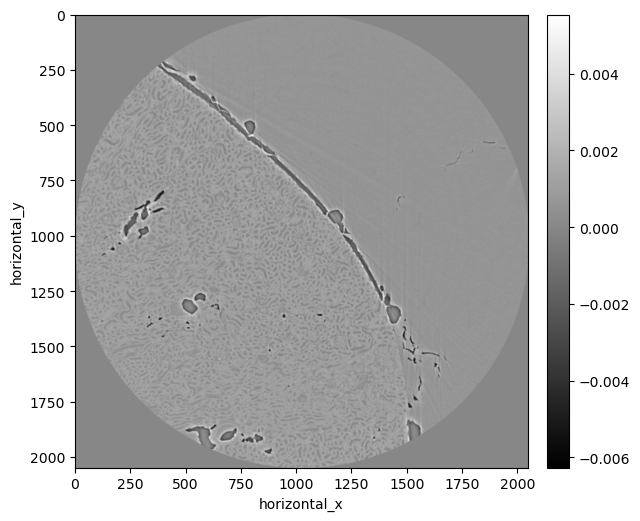

In [39]:
fbp = FBP(ig, ag_1024, device)
# run on the AcquisitionData
recon_fbp_1024 = fbp(data_pad_1024) * a
show2D(recon_fbp_1024, cmap=cmap, num_cols=1, size=(10,10), origin='upper-left')




# FISTA TV 200 iterations varying alpha

In [40]:
b = data_pad_1024
F = LeastSquares(A_1024, b)
x0 = ig_1024.allocate(0.0)

In [41]:
# Run 200 iterations of `myFISTATV` with:
alpha=0

GTV = alpha*FGP_TV(nonnegativity=False, device='gpu') 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  max_iteration=1000, 
                  update_objective_interval = 10)

In [42]:
myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.23529e+08
       10       1000         1.363                     
       20       1000         1.363                     
       30       1000         1.363                     
       40       1000         1.363                     
       50       1000         1.363                     
       60       1000         1.363                     
       70       1000         1.362                     
       80       1000         1.362                     
       90       1000         1.362                     
      100       1000         1.362                     
      110       1000         1.362                     
      120       1000         1.362                     
      130       1000         1.362                     
      140       1000         1.362                     
      150       1000         1.362              

In [43]:
im_crop = Slicer(roi={'horizontal_y': (1024, 3072, 1),
                      'horizontal_x': (1024, 3072, 1)})(myFISTATV.solution)

recon_fista_tv_0 = im_crop * a

In [44]:
alpha=0.001

GTV = alpha*FGP_TV(nonnegativity=False, device='gpu') 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  max_iteration=1000, 
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.23529e+08
       10       1000         1.379          8.88622e+05
       20       1000         1.380          4.65906e+05
       30       1000         1.381          3.67961e+05
       40       1000         1.381          3.24442e+05
       50       1000         1.380          3.00460e+05
       60       1000         1.380          2.85585e+05
       70       1000         1.380          2.75470e+05
       80       1000         1.380          2.68092e+05
       90       1000         1.380          2.62429e+05
      100       1000         1.380          2.57914e+05
      110       1000         1.380          2.54206e+05
      120       1000         1.380          2.51082e+05
      130       1000         1.380          2.48399e+05
      140       1000         1.380          2.46057e+05
      150       1000         1.380          2.43

In [45]:
im_crop = Slicer(roi={'horizontal_y': (1024, 3072, 1),
                      'horizontal_x': (1024, 3072, 1)})(myFISTATV.solution)

recon_fista_tv_0001 = im_crop * a

In [46]:
alpha=0.002

GTV = alpha*FGP_TV(nonnegativity=False, device='gpu') 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  max_iteration=1000, 
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.23529e+08
       10       1000         1.379          8.88622e+05
       20       1000         1.380          4.65906e+05
       30       1000         1.380          3.67962e+05
       40       1000         1.380          3.24442e+05
       50       1000         1.380          3.00461e+05
       60       1000         1.380          2.85586e+05
       70       1000         1.380          2.75471e+05
       80       1000         1.380          2.68093e+05
       90       1000         1.380          2.62430e+05
      100       1000         1.380          2.57915e+05
      110       1000         1.380          2.54207e+05
      120       1000         1.380          2.51084e+05
      130       1000         1.380          2.48400e+05
      140       1000         1.380          2.46059e+05
      150       1000         1.380          2.43

In [47]:
im_crop = Slicer(roi={'horizontal_y': (1024, 3072, 1),
                      'horizontal_x': (1024, 3072, 1)})(myFISTATV.solution)

recon_fista_tv_0002 = im_crop * a

In [48]:
alpha=0.005

GTV = alpha*FGP_TV(nonnegativity=False, device='gpu') 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  max_iteration=1000, 
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.23529e+08
       10       1000         1.380          8.88623e+05
       20       1000         1.379          4.65907e+05
       30       1000         1.380          3.67963e+05
       40       1000         1.380          3.24444e+05
       50       1000         1.380          3.00463e+05
       60       1000         1.380          2.85588e+05
       70       1000         1.380          2.75474e+05
       80       1000         1.381          2.68096e+05
       90       1000         1.381          2.62433e+05
      100       1000         1.380          2.57919e+05
      110       1000         1.380          2.54211e+05
      120       1000         1.380          2.51088e+05
      130       1000         1.380          2.48405e+05
      140       1000         1.380          2.46064e+05
      150       1000         1.380          2.43

In [49]:
im_crop = Slicer(roi={'horizontal_y': (1024, 3072, 1),
                      'horizontal_x': (1024, 3072, 1)})(myFISTATV.solution)

recon_fista_tv_0005 = im_crop * a

In [50]:
alpha=0.01

GTV = alpha*FGP_TV(nonnegativity=False, device='gpu') 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  max_iteration=1000, 
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.23529e+08
       10       1000         1.379          8.88623e+05
       20       1000         1.379          4.65908e+05
       30       1000         1.379          3.67965e+05
       40       1000         1.379          3.24447e+05
       50       1000         1.379          3.00466e+05
       60       1000         1.379          2.85593e+05
       70       1000         1.379          2.75479e+05
       80       1000         1.380          2.68102e+05
       90       1000         1.380          2.62440e+05
      100       1000         1.380          2.57926e+05
      110       1000         1.380          2.54219e+05
      120       1000         1.380          2.51096e+05
      130       1000         1.380          2.48413e+05
      140       1000         1.380          2.46073e+05
      150       1000         1.380          2.44

In [51]:
im_crop = Slicer(roi={'horizontal_y': (1024, 3072, 1),
                      'horizontal_x': (1024, 3072, 1)})(myFISTATV.solution)

recon_fista_tv_001 = im_crop * a

In [52]:
# Run 200 iterations of `myFISTATV` with:
alpha=0.02

GTV = alpha*FGP_TV(nonnegativity=False, device='gpu') 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  max_iteration=1000, 
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.23529e+08
       10       1000         1.379          8.88624e+05
       20       1000         1.379          4.65911e+05
       30       1000         1.380          3.67969e+05
       40       1000         1.380          3.24452e+05
       50       1000         1.379          3.00473e+05
       60       1000         1.380          2.85601e+05
       70       1000         1.380          2.75488e+05
       80       1000         1.380          2.68113e+05
       90       1000         1.380          2.62451e+05
      100       1000         1.380          2.57939e+05
      110       1000         1.380          2.54233e+05
      120       1000         1.380          2.51111e+05
      130       1000         1.380          2.48430e+05
      140       1000         1.379          2.46090e+05
      150       1000         1.379          2.44

In [53]:
im_crop = Slicer(roi={'horizontal_y': (1024, 3072, 1),
                      'horizontal_x': (1024, 3072, 1)})(myFISTATV.solution)

recon_fista_tv_002 = im_crop * a

In [54]:
alpha=0.05

GTV = alpha*FGP_TV(nonnegativity=False, device='gpu') 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  max_iteration=1000, 
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.23529e+08
       10       1000         1.378          8.88627e+05
       20       1000         1.378          4.65917e+05
       30       1000         1.378          3.67980e+05
       40       1000         1.378          3.24468e+05
       50       1000         1.378          3.00494e+05
       60       1000         1.378          2.85626e+05
       70       1000         1.378          2.75517e+05
       80       1000         1.378          2.68144e+05
       90       1000         1.379          2.62486e+05
      100       1000         1.379          2.57977e+05
      110       1000         1.379          2.54273e+05
      120       1000         1.379          2.51155e+05
      130       1000         1.379          2.48476e+05
      140       1000         1.379          2.46140e+05
      150       1000         1.379          2.44

In [55]:
im_crop = Slicer(roi={'horizontal_y': (1024, 3072, 1),
                      'horizontal_x': (1024, 3072, 1)})(myFISTATV.solution)

recon_fista_tv_005 = im_crop * a

In [56]:
# Run 200 iterations of `myFISTATV` with:
alpha=0.1

GTV = alpha*FGP_TV(nonnegativity=False, device='gpu') 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  max_iteration=1000, 
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.23529e+08
       10       1000         1.381          8.88632e+05
       20       1000         1.381          4.65929e+05
       30       1000         1.381          3.67998e+05
       40       1000         1.381          3.24494e+05
       50       1000         1.380          3.00527e+05
       60       1000         1.380          2.85666e+05
       70       1000         1.380          2.75563e+05
       80       1000         1.380          2.68195e+05
       90       1000         1.381          2.62542e+05
      100       1000         1.381          2.58038e+05
      110       1000         1.381          2.54338e+05
      120       1000         1.381          2.51224e+05
      130       1000         1.381          2.48550e+05
      140       1000         1.381          2.46218e+05
      150       1000         1.381          2.44

In [57]:
im_crop = Slicer(roi={'horizontal_y': (1024, 3072, 1),
                      'horizontal_x': (1024, 3072, 1)})(myFISTATV.solution)

recon_fista_tv_01 = im_crop * a

In [58]:
# Run 200 iterations of `myFISTATV` with:
alpha=0.2

GTV = alpha*FGP_TV(nonnegativity=False, device='gpu') 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  max_iteration=1000, 
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.23529e+08
       10       1000         1.381          8.88641e+05
       20       1000         1.380          4.65951e+05
       30       1000         1.380          3.68034e+05
       40       1000         1.380          3.24545e+05
       50       1000         1.381          3.00590e+05
       60       1000         1.381          2.85742e+05
       70       1000         1.381          2.75650e+05
       80       1000         1.381          2.68292e+05
       90       1000         1.381          2.62647e+05
      100       1000         1.381          2.58151e+05
      110       1000         1.381          2.54459e+05
      120       1000         1.381          2.51353e+05
      130       1000         1.381          2.48686e+05
      140       1000         1.381          2.46361e+05
      150       1000         1.381          2.44

In [59]:
im_crop = Slicer(roi={'horizontal_y': (1024, 3072, 1),
                      'horizontal_x': (1024, 3072, 1)})(myFISTATV.solution)

recon_fista_tv_02 = im_crop * a

In [60]:
# Run 200 iterations of `myFISTATV` with:
alpha=0.5

GTV = alpha*FGP_TV(nonnegativity=False, device='gpu') 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  max_iteration=1000, 
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.23529e+08
       10       1000         1.380          8.88669e+05
       20       1000         1.380          4.66015e+05
       30       1000         1.380          3.68138e+05
       40       1000         1.380          3.24687e+05
       50       1000         1.380          3.00772e+05
       60       1000         1.380          2.85956e+05
       70       1000         1.380          2.75890e+05
       80       1000         1.380          2.68557e+05
       90       1000         1.381          2.62935e+05
      100       1000         1.381          2.58459e+05
      110       1000         1.381          2.54785e+05
      120       1000         1.381          2.51696e+05
      130       1000         1.381          2.49047e+05
      140       1000         1.381          2.46739e+05
      150       1000         1.381          2.44

In [61]:
im_crop = Slicer(roi={'horizontal_y': (1024, 3072, 1),
                      'horizontal_x': (1024, 3072, 1)})(myFISTATV.solution)

recon_fista_tv_05 = im_crop * a

In [62]:
# Run 200 iterations of `myFISTATV` with:
alpha=1

GTV = alpha*FGP_TV(nonnegativity=False, device='gpu') 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  max_iteration=1000, 
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.23529e+08
       10       1000         1.380          8.88714e+05
       20       1000         1.380          4.66117e+05
       30       1000         1.380          3.68304e+05
       40       1000         1.380          3.24914e+05
       50       1000         1.380          3.01054e+05
       60       1000         1.380          2.86287e+05
       70       1000         1.380          2.76260e+05
       80       1000         1.380          2.68958e+05
       90       1000         1.380          2.63364e+05
      100       1000         1.381          2.58912e+05
      110       1000         1.381          2.55260e+05
      120       1000         1.381          2.52192e+05
      130       1000         1.381          2.49562e+05
      140       1000         1.381          2.47276e+05
      150       1000         1.381          2.45

In [63]:
im_crop = Slicer(roi={'horizontal_y': (1024, 3072, 1),
                      'horizontal_x': (1024, 3072, 1)})(myFISTATV.solution)

recon_fista_tv_1 = im_crop * a

In [64]:
# Run 200 iterations of `myFISTATV` with:
alpha=2

GTV = alpha*FGP_TV(nonnegativity=False, device='gpu') 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  max_iteration=1000, 
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.23529e+08
       10       1000         1.377          8.88803e+05
       20       1000         1.377          4.66318e+05
       30       1000         1.377          3.68622e+05
       40       1000         1.377          3.25346e+05
       50       1000         1.377          3.01586e+05
       60       1000         1.377          2.86906e+05
       70       1000         1.376          2.76949e+05
       80       1000         1.376          2.69697e+05
       90       1000         1.376          2.64145e+05
      100       1000         1.376          2.59728e+05
      110       1000         1.376          2.56108e+05
      120       1000         1.376          2.53069e+05
      130       1000         1.376          2.50468e+05
      140       1000         1.376          2.48209e+05
      150       1000         1.376          2.46

In [65]:
im_crop = Slicer(roi={'horizontal_y': (1024, 3072, 1),
                      'horizontal_x': (1024, 3072, 1)})(myFISTATV.solution)

recon_fista_tv_2 = im_crop * a

In [66]:
# Run 200 iterations of `myFISTATV` with:
alpha=5

GTV = alpha*FGP_TV(nonnegativity=False, device='gpu') 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  max_iteration=1000, 
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.23529e+08
       10       1000         1.378          8.89061e+05
       20       1000         1.377          4.66886e+05
       30       1000         1.377          3.69523e+05
       40       1000         1.377          3.26543e+05
       50       1000         1.377          3.03052e+05
       60       1000         1.377          2.88588e+05
       70       1000         1.377          2.78788e+05
       80       1000         1.377          2.71668e+05
       90       1000         1.377          2.66220e+05
      100       1000         1.377          2.61885e+05
      110       1000         1.377          2.58332e+05
      120       1000         1.377          2.55355e+05
      130       1000         1.377          2.52813e+05
      140       1000         1.377          2.50614e+05
      150       1000         1.377          2.48

In [67]:
im_crop = Slicer(roi={'horizontal_y': (1024, 3072, 1),
                      'horizontal_x': (1024, 3072, 1)})(myFISTATV.solution)

recon_fista_tv_5 = im_crop * a

In [68]:
# Run 200 iterations of `myFISTATV` with:
alpha=10

GTV = alpha*FGP_TV(nonnegativity=False, device='gpu') 
myFISTATV = FISTA(f=F, 
                  g=GTV, 
                  initial=x0 ,
                  max_iteration=1000, 
                  update_objective_interval = 10)

myFISTATV.run(200,verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.23529e+08
       10       1000         1.376          8.89474e+05
       20       1000         1.376          4.67782e+05
       30       1000         1.376          3.70895e+05
       40       1000         1.376          3.28345e+05
       50       1000         1.376          3.05215e+05
       60       1000         1.376          2.91050e+05
       70       1000         1.376          2.81483e+05
       80       1000         1.376          2.74513e+05
       90       1000         1.376          2.69182e+05
      100       1000         1.376          2.64944e+05
      110       1000         1.376          2.61481e+05
      120       1000         1.376          2.58588e+05
      130       1000         1.376          2.56129e+05
      140       1000         1.376          2.54014e+05
      150       1000         1.375          2.52

In [69]:
im_crop = Slicer(roi={'horizontal_y': (1024, 3072, 1),
                      'horizontal_x': (1024, 3072, 1)})(myFISTATV.solution)

recon_fista_tv_10 = im_crop * a

In [70]:
save_base_path = '/dtu/cfu/data/userdata18/s220464/storage/slice7_fista_200_1024/'

# Dictionary mapping numbers to data variables
data_map = {
    0: recon_fista_tv_0,
    0.001: recon_fista_tv_0001,
    0.002: recon_fista_tv_0002,
    0.005: recon_fista_tv_0005,
    0.01: recon_fista_tv_001,
    0.02: recon_fista_tv_002,
    0.05: recon_fista_tv_005,
    0.1: recon_fista_tv_01,
    0.2: recon_fista_tv_02,
    0.5: recon_fista_tv_05,
    1: recon_fista_tv_1,
    2: recon_fista_tv_2,
    5: recon_fista_tv_5,
    10: recon_fista_tv_10,
}

# Loop through the data map
for number, data in data_map.items():
    save_path = os.path.join(save_base_path, f'recon_fista_tv_{number}.tiff')
    TIFFWriter(data=data, file_name=save_path).write()